In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import math
import random
import pandas as pd
from scipy import stats
from sklearn import metrics
plt.rcParams["figure.figsize"] = (20,12)

import seaborn as sns
sns.set_theme(style="darkgrid")


In [2]:
# loading images
train_img = [cv2.imread(file) for file in glob.glob('./P6/pratheepan/train/set1/images/*')]
train_img += [cv2.imread(file) for file in glob.glob('./P6/pratheepan/train/set2/images/*')]

train_label = [cv2.imread(file) for file in glob.glob('./P6/pratheepan/train/set1/groundtruth/*')]
train_label += [cv2.imread(file) for file in glob.glob('./P6/pratheepan/train/set2/groundtruth/*')]

In [4]:
# Calculating Prior prob
P_skin = 0
P_non_skin = 0

skin_pix = []
non_skin_pix = []

for i in range(len(train_label)):
    for _ in range(train_label[i].shape[0]):
        for __ in range(train_label[i].shape[1]):
            if train_label[i][_][__][0] == 255 :
                P_skin += 1
                skin_pix.append(train_img[i][_][__])
            else:
                P_non_skin +=1
                non_skin_pix.append(train_img[i][_][__])
                
P_skin,P_non_skin =  P_skin/(P_skin+P_non_skin), P_non_skin/(P_skin+P_non_skin)    


In [5]:
# Mean calculation
non_skin_mean = np.mean(non_skin_pix)
skin_mean = np.mean(skin_pix)

# Variance calculation
non_skin_var = np.var(non_skin_pix)
skin_var = np.var(skin_pix)

In [6]:
# multivariate normal pdf function to calculate prob of each pixel
skin_pdf = stats.multivariate_normal(skin_mean,skin_var)
non_skin_pdf = stats.multivariate_normal(non_skin_mean,non_skin_var)

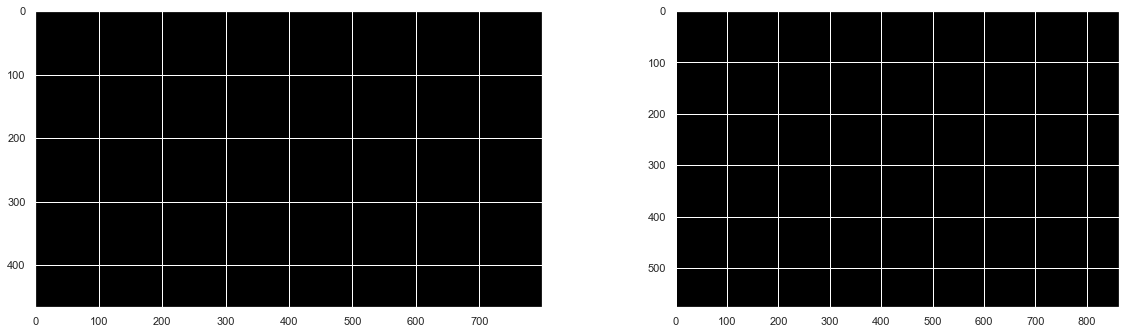

In [7]:
def BayesSkinClassifier(images,cost=1.685):
    plot_index = 1
    threshold = P_non_skin/P_skin
    for img in images:
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                pix = np.mean(img[row][col])
                prob_skin = skin_pdf.pdf(pix)
                prob_non_skin = non_skin_pdf.pdf(pix)
                if prob_skin/prob_non_skin > threshold/cost:
                    img[row][col] = (255,255,255)
                else:
                    img[row][col] = (0,0,0)
                
        plt.subplot(int(len(images)/2)+1,2,plot_index)
        plt.imshow(img)
        import os
        if not os.path.exists("./P6/i - Groundtruth Predicted"):
            os.makedirs("./P6/i - Groundtruth Predicted")
        plt.imsave('./P6/i - Groundtruth Predicted/Bayes Photo {0} - {1}x{2}.jpg'.format(plot_index,row,col), img)
        plot_index += 1
    plt.show()

trump = [cv2.imread(file) for file in glob.glob('./P6/*.jpg')]
BayesSkinClassifier(trump)

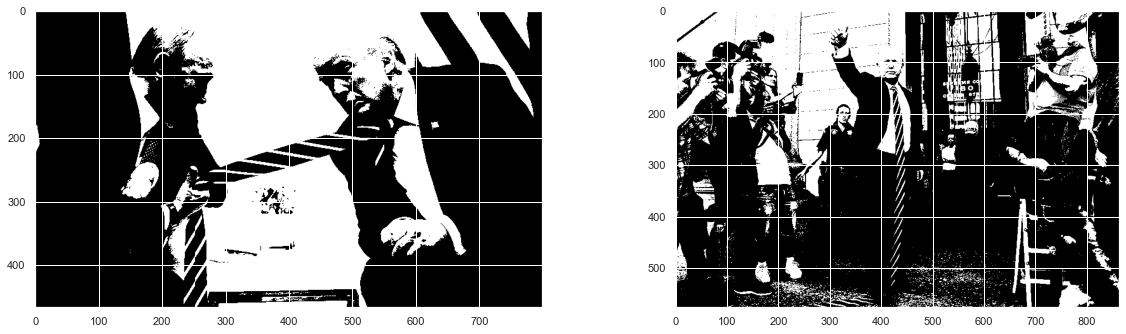

In [8]:
def MinDisClassifier(images,imshow_cout=2,Labels=None):
    plot_index = 1
    CM = np.zeros((2, 2))
    PredictedLabel = []
    Groundtruth = []
    for img_index in range(len(images)):
        for row in range(images[img_index].shape[0]):
            for col in range(images[img_index].shape[1]):
                pix = np.mean(images[img_index][row][col])
                skin_dis = abs(skin_mean-pix)
                non_skin_dis = abs(non_skin_mean-pix)
                predicted = 0
                if skin_dis< non_skin_dis:
                    images[img_index][row][col] = (255,255,255)
                    predicted = 1
                else:
                    images[img_index][row][col] = (0,0,0)
                if Labels :
                    label = 0
                    if Labels[img_index][row][col][0] == 255 :
                        label = 1
                    CM[predicted][label] +=1
                    PredictedLabel.append(predicted)
                    Groundtruth.append(label)                        
                    
        plt.subplot(int(len(images)/imshow_cout)+1,imshow_cout,plot_index)
        plt.imshow(images[img_index])
        plot_index += 1
        import os
        if not os.path.exists("./P6/i - Groundtruth Predicted"):
            os.makedirs("./P6/i - Groundtruth Predicted")
        plt.imsave('./P6/i - Groundtruth Predicted/MDC Photo {0} - {1}x{2}.jpg'.format(img_index,row,col), images[img_index])
    plt.show()
    if Labels :
        return CM,PredictedLabel,Groundtruth
                    
trump = [cv2.imread(file) for file in glob.glob('./P6/*.jpg')]
MinDisClassifier(trump,2)

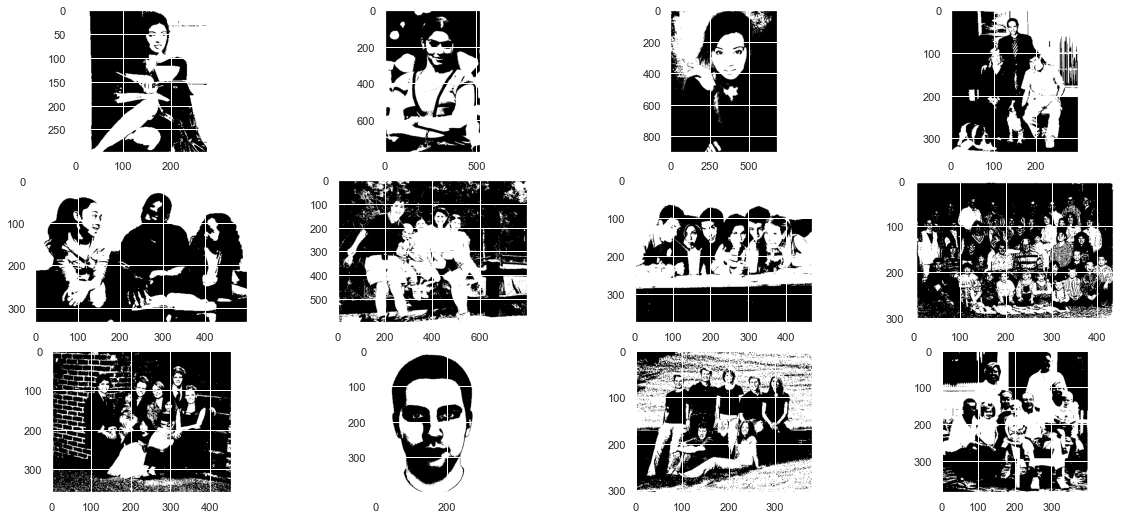

In [9]:
test_img = [cv2.imread(file) for file in glob.glob('./P6/pratheepan/test/images/*')]
test_label = [cv2.imread(file) for file in glob.glob('./P6/pratheepan/test/groundtruth/*')]
CM,PredictedLabel,Groundtruth = MinDisClassifier(test_img,4,test_label)


Error pixels count are 893536 out of all pixels(2713178) => 32.93%


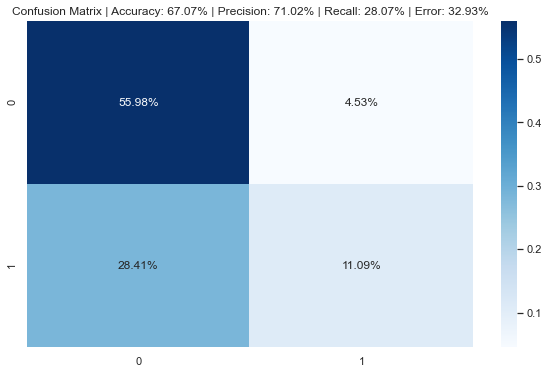

In [10]:
total = CM[0][0]+CM[1][1]+CM[1][0]+CM[0][1]
Accuracy = round((CM[0][0]+CM[1][1])/total*100,2)
Precision = round(CM[1][1]/(CM[1][1]+CM[0][1])*100,2)
Recall = round(CM[1][1]/(CM[1][1]+CM[1][0])*100,2)
error = round((CM[1][0]+CM[0][1])/total*100,2)
print("Error pixels count are {0} out of all pixels({1}) => {2}%".format(int(CM[1][0]+CM[0][1]),int(total),error))
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(CM/total, annot=True, cmap='Blues',fmt=".2%")
plt.title("Confusion Matrix | Accuracy: {0}% | Precision: {1}% | Recall: {2}% | Error: {3}%".format(Accuracy,Precision,Recall,error))
plt.show()
plt.rcParams["figure.figsize"] = (20,12)

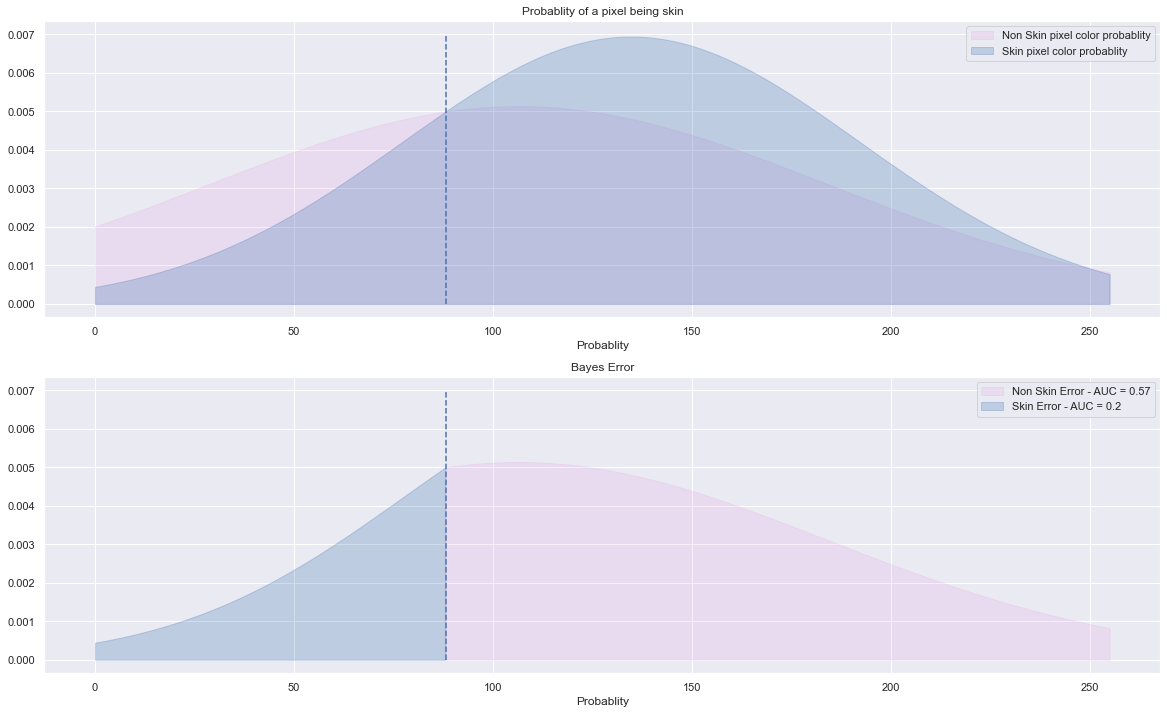

In [11]:
#Plotting probablity of classes
skin_pdf = stats.multivariate_normal(skin_mean,skin_var)
non_skin_pdf = stats.multivariate_normal(non_skin_mean,non_skin_var)
PlotRange = np.arange(0,255.1,0.1)
skin_plot = [skin_pdf.pdf(x) for x in PlotRange]
non_skin_plot = [non_skin_pdf.pdf(x) for x in PlotRange]

Threshold = 0
for i in range(len(skin_plot)):
    if skin_plot[i] >=non_skin_plot[i]:
        Threshold = i/10
        break

plt.subplot(2,1,1)
plt.plot([Threshold,Threshold],[0,0.007],'--')
plt.fill_between(PlotRange, non_skin_plot, color='#e6a3e3', alpha=0.2,label="Non Skin pixel color probablity")
plt.fill_between(PlotRange, skin_plot, color='#0b559f', alpha=0.2,label="Skin pixel color probablity")
plt.title("Probablity of a pixel being skin")
plt.xlabel("Pixel brightness | 0-255")
plt.xlabel("Probablity")
plt.legend()


plt.subplot(2,1,2)
PlotRange_Non_skin = np.arange(0,Threshold,0.1)
PlotRange_skin = np.arange(Threshold,255.1,0.1)

skin_plot = [skin_pdf.pdf(x) for x in PlotRange_Non_skin]
non_skin_plot = [non_skin_pdf.pdf(x) for x in PlotRange_skin]

auc_non_skin = round(metrics.auc(PlotRange_skin, non_skin_plot),2)
auc_skin = round(metrics.auc(PlotRange_Non_skin, skin_plot),2)

plt.plot([Threshold,Threshold],[0,0.007],'--')
plt.fill_between(PlotRange_skin, non_skin_plot, color='#e6a3e3', alpha=0.2,label="Non Skin Error - AUC = {0}".format(auc_non_skin))
plt.fill_between(PlotRange_Non_skin, skin_plot, color='#0b559f', alpha=0.2,label="Skin Error - AUC = {0}".format(auc_skin))
plt.title("Bayes Error")
plt.xlabel("Pixel brightness | 0-255")
plt.xlabel("Probablity")
plt.legend()

plt.show()

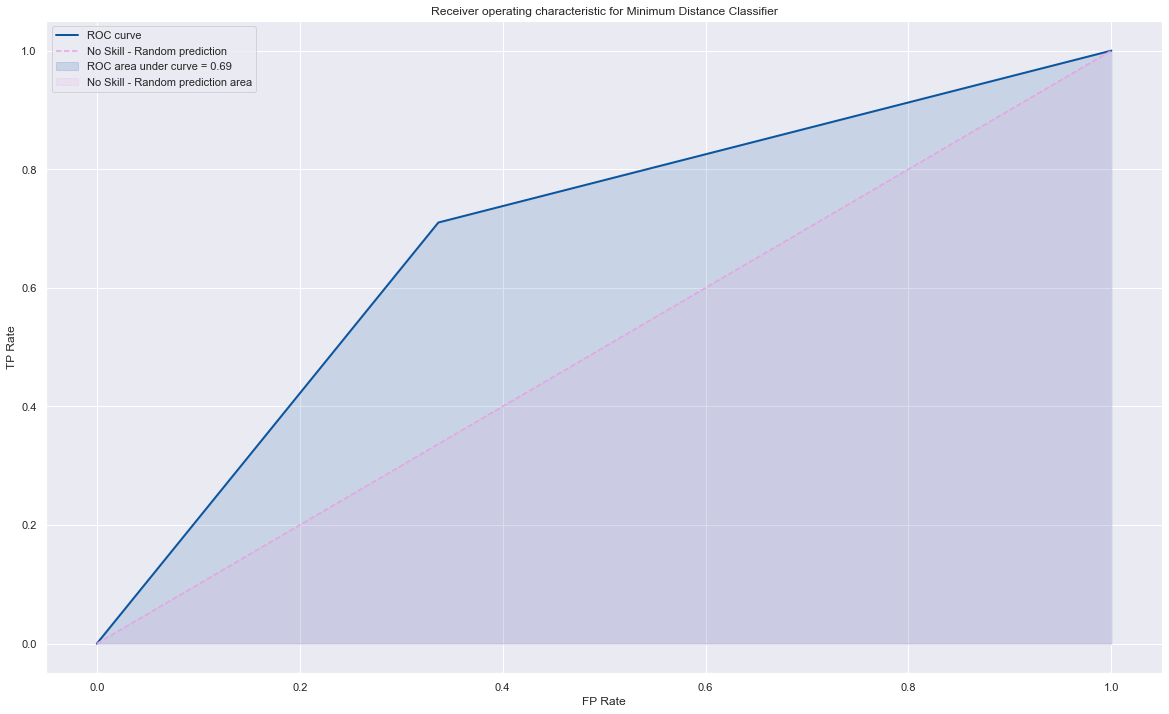

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(Groundtruth, PredictedLabel, pos_label=1)
roc_auc = round(metrics.auc(fpr, tpr),2)
plt.figure()
plt.plot(fpr, tpr,color='#0b559f', label='ROC curve'.format(roc_auc),lw=2)
plt.fill_between(fpr, tpr, color='#0b559f', alpha=0.15,label='ROC area under curve = {0}'.format(roc_auc))
plt.plot([0,1], [0,1],'--',color='#e6a3e3', label='No Skill - Random prediction')
plt.fill_between([0,1], [0,1], color='#e6a3e3', alpha=0.15,label='No Skill - Random prediction area')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Receiver operating characteristic for Minimum Distance Classifier')
plt.legend()
plt.show()